<a href="https://colab.research.google.com/github/Untick/NetOptik/blob/Polyakov-Alexander-branch/Polyakov%20Alexander/EfficientNet_3_classes_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Подготовка

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
DATA_DIR = '/content/drive/MyDrive/AI/datasets/arches/train/'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255, validation_split=0.2)

datagen_train = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,      # использовать 20% данных для валидации
    rotation_range=20,         # случайный поворот на ±20 градусов
    width_shift_range=0.2,     # случайный сдвиг по ширине на ±20%
    height_shift_range=0.2,    # случайный сдвиг по высоте на ±20%
    zoom_range=0.2,            # случайное увеличение/уменьшение на ±20%
    horizontal_flip=True,      # случайное отражение по горизонтали
    brightness_range=[0.8, 1.2] # изменение яркости от 80% до 120%
)


train_generator = datagen_train.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen_train.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 960 images belonging to 3 classes.
Found 240 images belonging to 3 classes.


### Сравнение моделей


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
import importlib

def get_efficientnet_model(version):
    module = importlib.import_module("tensorflow.keras.applications")
    class_name = f"EfficientNetB{version}"
    class_ = getattr(module, class_name)
    return class_(weights='imagenet', include_top=False)

# Пример использования:
model = get_efficientnet_model(0)
model

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
def train_efficientnet(version, epochs=10):
    base_model = get_efficientnet_model(version)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Отключаем обучение базовых слоев
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
      train_generator,
      validation_data=val_generator,
      epochs=epochs
    )

    max_val_accuracy = max(history.history['val_accuracy'])
    return max_val_accuracy


In [ ]:
results = {}

for i in range(8):
    val_acc = train_efficientnet(i, epochs=5)
    results[f"EfficientNetB{i}"] = val_acc

Epoch 1/5
30/30 [==============================] - 580s 19s/step - loss: 1.2509 - accuracy: 0.3323 - val_loss: 1.1056 - val_accuracy: 0.3333
Epoch 2/5
30/30 [==============================] - 30s 1s/step - loss: 1.1097 - accuracy: 0.3615 - val_loss: 1.1188 - val_accuracy: 0.3333
Epoch 3/5
30/30 [==============================] - 31s 1s/step - loss: 1.1174 - accuracy: 0.3208 - val_loss: 1.1279 - val_accuracy: 0.3333
Epoch 4/5
30/30 [==============================] - 30s 1s/step - loss: 1.1325 - accuracy: 0.2969 - val_loss: 1.1100 - val_accuracy: 0.3333
Epoch 5/5
27018416/27018416 [==============================] - 2s 0us/step
Epoch 1/5
30/30 [==============================] - 43s 1s/step - loss: 1.2264 - accuracy: 0.3479 - val_loss: 1.1029 - val_accuracy: 0.4042
Epoch 2/5
30/30 [==============================] - 30s 1s/step - loss: 1.1152 - accuracy: 0.3594 - val_loss: 1.0996 - val_accuracy: 0.3958
Epoch 3/5
30/30 [==============================] - 30s 1s/step - loss: 1.1152 - accuracy:

In [ ]:
import pandas as pd

df = pd.DataFrame(list(results.items()), columns=['Model', 'Validation Accuracy'])
print(df)

            Model  Validation Accuracy
0  EfficientNetB0             0.333333
1  EfficientNetB1             0.404167
2  EfficientNetB2             0.466667
3  EfficientNetB3             0.508333
4  EfficientNetB4             0.483333
5  EfficientNetB5             0.533333
6  EfficientNetB6             0.554167
7  EfficientNetB7             0.450000


### Обучение лучшей модели

In [ ]:
best_model_dir = '/content/drive/MyDrive/AI/datasets/arches/best_models/'


In [ ]:
base_model = EfficientNetB5(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Dissable train base layers
# for layer in base_model.layers:
#     layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

115263384/115263384 [==============================] - 6s 0us/step


In [ ]:
checkpoint_callback = ModelCheckpoint(
    best_model_dir + 'best_model_EfficientNetB5_val_accuracy_scratch.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=300,
    callbacks=[checkpoint_callback]
)

Epoch 1/300
30/30 [==============================] - ETA: 0s - loss: 0.4725 - accuracy: 0.8354 

KeyboardInterrupt: ignored

NameError: ignored

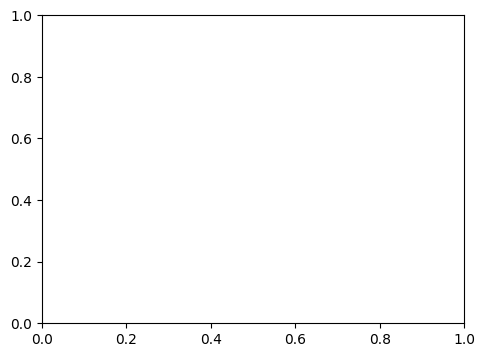

In [ ]:
import matplotlib.pyplot as plt

# Визуализация потерь
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

# Визуализация точности
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
datagen = ImageDataGenerator(rescale=1./255)
plt.show()

### Проверка лучшей модели

In [12]:
from tensorflow.keras.models import load_model

best_model_dir = '/content/drive/MyDrive/AI/datasets/arches/best_models/'

model = load_model(best_model_dir + 'best_model_EfficientNetB3_val_accuracy_scratch.h5')

Found 214 images belonging to 3 classes.
7/7 [==============================] - 6s 383ms/step - loss: 0.6735 - accuracy: 0.9159
Test accuracy: 0.9158878326416016
7/7 [==============================] - 5s 267ms/step


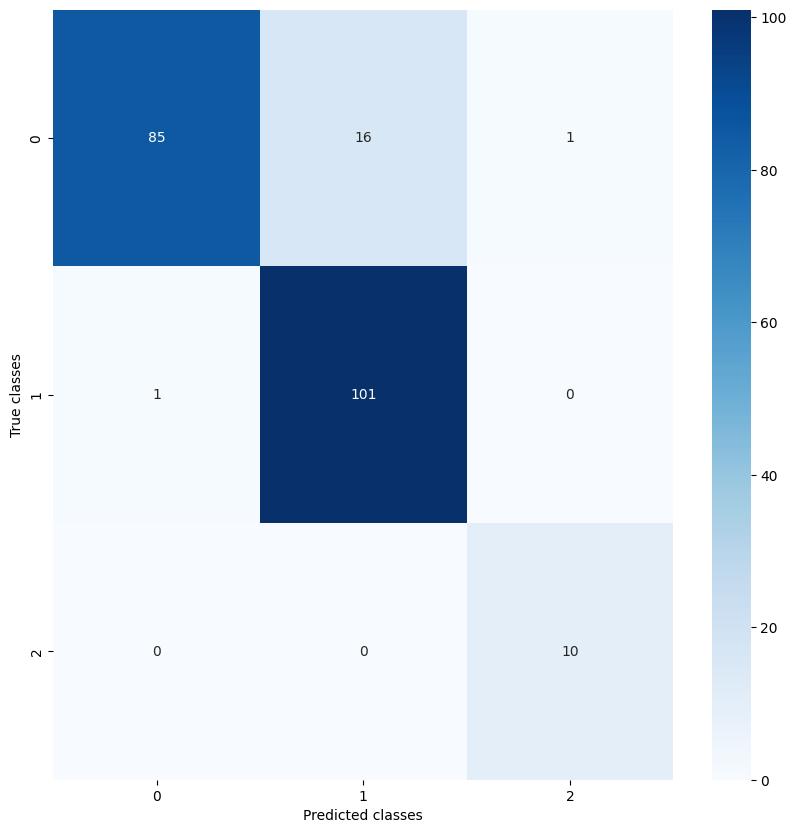

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


TEST_DIR = '/content/drive/MyDrive/AI/datasets/arches/test/'
datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Это важно! Для сохранения исходного порядка
)

loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}')

# Предсказания модели
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Истинные классы
true_classes = test_generator.classes

# Создание confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Визуализация
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.show()
